## NBA Player Statistics — Predictive Modeling (Stacking)### Team TSIAUF — Sanzhar Ilichbekov, Nurbekov Mirlan, Aydraliev Atai.F

In this notebook, we build a **Stacking Classifier** to predict whether a player's team will **Win** or **Lose** based on their game statistics.

As defined in our project methodology, Stacking is an ensemble learning technique. It combines the predictions of multiple "base" models to create a final "meta" model that is often more accurate than any single model alone.

**Our Approach:**
1.  **Base Models:** Random Forest (handles complex data) and Decision Tree (simple rules).
2.  **Meta Model:** Logistic Regression (makes the final decision).
3.  **Evaluation:** We will check Accuracy, Precision, Recall, and F1-Score.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib

In [11]:
df = pd.read_csv(r"../data/cleaned_player_stats_for_model.csv")
df.head()

,firstName,lastName,personId,gameId,gameDateTimeEst,playerteamCity,playerteamName,opponentteamCity,opponentteamName,win,...,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints,efficiency,points_per36,gameYear,gameMonth
0,Chris,Paul,101108,22500300,2025-11-29 17:00:00+00:00,21,9,10,21,0,...,2.0,0.0,2.0,2.0,0.0,-2.0,6.0,0.000000,2025,11
1,D'Angelo,Russell,1626156,22500300,2025-11-29 17:00:00+00:00,10,21,21,9,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2025,11
2,Kris,Dunn,1627739,22500300,2025-11-29 17:00:00+00:00,21,9,10,21,0,...,3.0,0.0,3.0,2.0,1.0,8.0,12.0,6.654344,2025,11
3,Ivica,Zubac,1627826,22500300,2025-11-29 17:00:00+00:00,21,9,10,21,0,...,9.0,2.0,11.0,5.0,2.0,4.0,34.0,18.225420,2025,11
4,John,Collins,1628381,22500300,2025-11-29 17:00:00+00:00,21,9,10,21,0,...,4.0,0.0,4.0,2.0,1.0,1.0,28.0,20.982515,2025,11


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637622 entries, 0 to 1637621
Data columns (total 35 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   firstName                1637622 non-null  object 
 1   lastName                 1637622 non-null  object 
 2   personId                 1637622 non-null  int64  
 3   gameId                   1637622 non-null  int64  
 4   gameDateTimeEst          1637622 non-null  object 
 5   playerteamCity           1637622 non-null  int64  
 6   playerteamName           1637622 non-null  int64  
 7   opponentteamCity         1637622 non-null  int64  
 8   opponentteamName         1637622 non-null  int64  
 9   win                      1637622 non-null  int64  
 10  home                     1637622 non-null  int64  
 11  numMinutes               1637622 non-null  float64
 12  points                   1637622 non-null  float64
 13  assists                  1637622 non-null 

### Feature Selection and Splitting

We select the columns that are most likely to influence the game result. We chose features like `plusMinusPoints`, `efficiency`, and `points`.
We then split the data: **80% for training** the model and **20% for testing** it.

In [13]:
feature_cols = ['points', 'assists', 'reboundsTotal', 'steals', 'blocks', 'turnovers', 'efficiency', 'foulsPersonal', 'plusMinusPoints', 'numMinutes']

X = df[feature_cols]
y = df['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape:  {X_test.shape}")

Training Data Shape: (1310097, 10)
Testing Data Shape:  (327525, 10)


### Building the Stacking Model

We define our stacking architecture with multiple base learners and a final estimator:

* **Base Learner 1:** `RandomForestClassifier`  
  - Captures non-linear relationships in the data.  
  - Works well with large datasets and many features.

* **Base Learner 2:** `DecisionTreeClassifier`  
  - Splits data based on clear decision rules.  
  - Simple and interpretable, helps the stack learn basic patterns.

* **Base Learner 3:** `LogisticRegression`  
  - Linear model that provides an additional perspective.  
  - Helps capture linear relationships that tree models may miss.

* **Base Learner 4:** `GaussianNB`  
  - Probabilistic model based on feature distributions.  
  - Provides complementary insights to the other learners.

* **Base Learner 5:** `LGBMClassifier`  
  - Gradient boosting model that is fast and accurate.  
  - Learns complex patterns in the data efficiently.

* **Base Learner 6:** `XGBClassifier`  
  - Another gradient boosting model with strong predictive power.  
  - Helps capture subtle patterns and interactions in the features.

* **Final Estimator:** `LogisticRegression`  
  - Takes the predictions from all base learners.  
  - Outputs the final probability for the target variable.

This stacking approach combines the strengths of tree-based, linear, and probabilistic models, allowing the ensemble to learn from different perspectives and improve overall predictive performance.
ning)

In [26]:
base_learners = [
    ('rf', RandomForestClassifier(
        n_estimators=80,
        max_depth=18,
        n_jobs=9,
        random_state=42
    )),

    ('dt', DecisionTreeClassifier(
        max_depth=12,
        random_state=42
    )),

    ('lr', LogisticRegression(
        max_iter=400,
        n_jobs=9
    )),

    ('nb', GaussianNB()),

    ('lgbm', LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=64,
        subsample=0.8,
        n_jobs=9
    )),

    ('xgb', XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        n_jobs=9,
        eval_metric='logloss',
        verbosity=0
    ))
]


stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=500),
    cv=3,
    n_jobs=9
)

stacking_model.fit(X_train_scaled, y_train)
print("Training Complete!")

Training Complete!


### Model Evaluation

We evaluate our model on the Test set (data the model has never seen before). We look at:
*   **Accuracy:** Overall correctness.
*   **Precision:** When it predicts a win, how often is it right?
*   **Recall:** Out of all actual wins, how many did we catch?
*   **F1-Score:** A balance between Precision and Recall.

In [29]:
y_pred = stacking_model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("--- Stacking Model Performance ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))

C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Stacking Model Performance ---
Accuracy:  0.6340
Precision: 0.6350
Recall:    0.6317
F1-Score:  0.6334

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.63      0.64      0.63    163626
           1       0.64      0.63      0.63    163899

    accuracy                           0.63    327525
   macro avg       0.63      0.63      0.63    327525
weighted avg       0.63      0.63      0.63    327525



### Confusion Matrix

The confusion matrix helps us visualize where the model makes mistakes.
*   **True Positives:** Correctly predicted Wins.
*   **True Negatives:** Correctly predicted Losses.

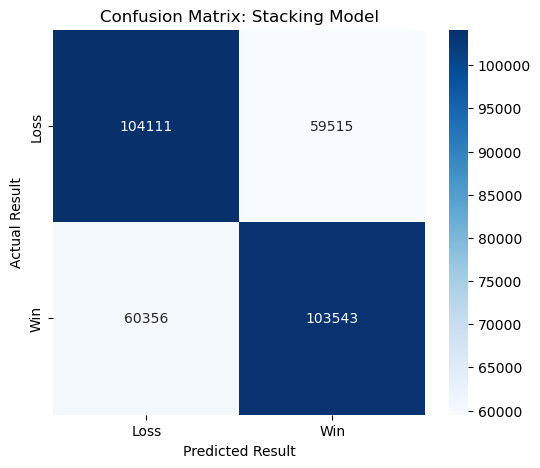

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix: Stacking Model')
plt.ylabel('Actual Result')
plt.xlabel('Predicted Result')
plt.show()

### Saving the Model

We save the trained model to a file.

In [35]:
joblib.dump(stacking_model, r"../model/saved_stacking_model.pkl")
print("Stacking Model saved successfully to the 'models' folder.")

Stacking Model saved successfully to the 'models' folder.
